<a href="https://colab.research.google.com/github/mabittar/Portfolio/blob/master/YouTube_Scaper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Informações e Estatistas de canais do YouTube

Esse notebook nasceu como um exercício de fixação de conceitos de criação e utilização de um  Web Scraper para obtenção de dados estatísticos de canais do YouTube.

Adiante será visto que existem restrições e limitações para a utilização dessa ferramenta. O Youtuber promove a utilização de API's, portanto foi possível utilizar-se dessa ferramenta para contornar essa restrição.

## Web Scraper 

Nesse web scraper  veremos como criar um algoritmo para baixar os metadados dos vídeos publicados em um canal do Youtube utilizando o [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/).

Esse é apenas um exemplo de aplicação de um Crawler, que pode ser utilizado para registrar preços de um produto, oportunidades de imóveis para venda ou locação, disponibilidade de servidores e assim por diante.

Web Crawler, bot ou web spider é um algoritmo utilizado para encontrar, ler e gravar informações de páginas da internet. É como um robô que varre o caminho indicado e captura as informações que encontra pela frente.

Um dos maiores exemplos de um web crawler é o próprio google. Antes do site estar disponível para pesquisa, um robô lê o web site e cataloga as informações de forma a serem recuperadas numa busca futura.


Para esse web scrapper dividi o script em funções específicas a fim de facilitar qualquer possível manutenção.

### Connect to Target

Gosto muito dos vídeos publicados no canal [Programação Dinâmica](https://www.youtube.com/c/Programa%C3%A7%C3%A3oDin%C3%A2mica/videos), sempre quando tenho alguma dúvida específica procuro o canal deles. Deixo aqui meu agradecimento a eles, pois tenho aprendido muito com o Hallison e a Kizzy.

Resolvi fazer esse scraper como uma forma de fixar o aprendizado e explorar o pouco mais da biblioteca Selenium.

#### Iniciando o Selenium no Colab

In [ ]:
!pip install selenium
!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver',chrome_options=chrome_options)
wd.implicitly_wait(10)

     |████████████████████████████████| 911kB 5.5MB/s 
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/g

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: use options instead of chrome_options
  if sys.path[0] == '':


In [ ]:
# importando demais bibliotecas necessárias
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import requests
import datetime
import time

In [ ]:
# conectando ao site
link = 'https://www.youtube.com/c/Programa%C3%A7%C3%A3oDin%C3%A2mica/videos'

In [ ]:
def get_data(link):

  """
  essa função mapeia o canal alvo e retorna os videos listados
  entrada: link para o alvo
  saída: lista de com videos do canal
  """
  response = requests.get(link)
  if response.status_code != 200:
    raise RuntimeError(f'Houve um erro de conexão. Cód: {response.status_code}')

  # conectando ao site
  wd.get(link)

  #navegando até o final da página
  for _ in range(56):
    wd.find_element_by_tag_name('body').send_keys(Keys.END)

  #obtendo dados do site:
  html = wd.page_source
  soup = BeautifulSoup(html, 'html.parser')
  videos = soup.find_all('div', {"id": "dismissable"})

  return videos

In [ ]:
videos = get_data(link)

In [ ]:
# checado a quantidade de itens armazenados
len(videos)

244

### Obtendo metadados do canal

In [ ]:
# obtendo metadados

meta_list = []

for video in videos:
  meta_d = {}
  meta_d['title'] = video.find('a', {'id': 'video-title'}).text
  meta_d['link'] = "https://www.youtube.com/" + video.find('a', {'id': 'video-title'})['href']
  meta = video.find('div', {'id': 'metadata-line'}).find_all('span')
  meta_d['vis'] = meta[0].text
  meta_d['publ'] = meta[1].text
  meta_list.append(meta_d)
  

In [ ]:
# Convertendo para um Pandas DataFrame
df = pd.DataFrame(meta_list)
df

,title,link,vis,publ
0,Uma LINGUAGEM para CIÊNCIA de DADOS? | Handsha...,https://www.youtube.com//watch?v=Tj0CUAyxjck,2 waiting,"Premieres 1/19/21, 8:00 PM"
1,MELHOR MÉTODO para ENTENDER e CONVERSAR em ING...,https://www.youtube.com//watch?v=X-23dxiSsxw,2.2K views,2 days ago
2,NÃO É SÓ O WHATSAPP? SUA PRIVACIDADE ESTÁ EM J...,https://www.youtube.com//watch?v=_QFSjhUaJZ8,21K views,4 days ago
3,ADEUS WHATSAPP? ENTENDA OS NOVOS TERMOS DE PRI...,https://www.youtube.com//watch?v=qAUbkKtqqZA,100K views,6 days ago
4,"O Que é Árvore AVL, Propriedades da Árvore AVL...",https://www.youtube.com//watch?v=l8IBdCb2BWA,751 views,1 week ago
...,...,...,...,...
239,O QUE É e como se utiliza UMA VARIÁVEL? | Pyth...,https://www.youtube.com//watch?v=tZ-3EGw5IPw,1.1K views,3 years ago
240,Comparando Números,https://www.youtube.com//watch?v=pB0UeU7SIo0,1.1K views,3 years ago
241,Operando com Números em Python,https://www.youtube.com//watch?v=hysCU5CWl80,1.8K views,3 years ago
242,Instalando Python,https://www.youtube.com//watch?v=_RadDQpPGM0,2K views,3 years ago


### Tratando dados

In [ ]:
def converter_vis(df):
  """ essa funcão converte os dados da coluna visualizações e subsititui as strings por números
  entrada: dataframe com a coluna['vis']
  processamento: recebe os dados da coluna e com base nas confições faz a substituição
  saída: dados tratados e devem ser atribuídos a uma nova coluna
  """
  if 'K' in df['vis']:
    k_views = float(df['vis'].split('K')[0])*1000
    return k_views
  elif 'M' in df['vis']:
    m_views = float(df['vis'].split('M')[0])*1000000
    return m_views
  else:
    views = float(df['vis'].split(' ')[0])
    return views

In [ ]:
# Convertendo a visualização para inteiros
df['vis_conv'] = df.apply(converter_vis, axis=1)
df['vis_conv'] = df['vis_conv'].astype(int)

In [ ]:
df['title'] = df['title'].astype(str)
df['publ'] = df['publ'].astype(str)

In [ ]:
df.head()

,title,link,vis,publ,vis_conv
0,Uma LINGUAGEM para CIÊNCIA de DADOS? | Handsha...,https://www.youtube.com//watch?v=Tj0CUAyxjck,2 waiting,"Premieres 1/19/21, 8:00 PM",2
1,MELHOR MÉTODO para ENTENDER e CONVERSAR em ING...,https://www.youtube.com//watch?v=X-23dxiSsxw,2.2K views,2 days ago,2200
2,NÃO É SÓ O WHATSAPP? SUA PRIVACIDADE ESTÁ EM J...,https://www.youtube.com//watch?v=_QFSjhUaJZ8,21K views,4 days ago,21000
3,ADEUS WHATSAPP? ENTENDA OS NOVOS TERMOS DE PRI...,https://www.youtube.com//watch?v=qAUbkKtqqZA,100K views,6 days ago,100000
4,"O Que é Árvore AVL, Propriedades da Árvore AVL...",https://www.youtube.com//watch?v=l8IBdCb2BWA,751 views,1 week ago,751


## Alguns Insights

Até essa etapa obtivemos uma quantidade razoável de dados, vamos observar alguns dados.

In [ ]:
print('O total de publicações no canal são {} vídeos.' .format(len(df)))

O total de publicações no canal são 244 vídeos.


In [ ]:
# podemos obter o total de visualizações do canal:
out_sum = df['vis_conv'].sum()
print('A soma total de visualizações é {:,}.' .format(out_sum))

A soma total de visualizações é 1,164,481.


In [ ]:
# obter os metadados do vídeo mais visualizado
out_max = df.loc[df['vis_conv'] == df['vis_conv'].max()]

# obtendo o título
title_max  = out_max['title'].values[0]
# obtendo a data de publicação
publ_max = out_max['publ'].values[0]

# retornando informações
print('O vídeo mais visualizado foi: {}'.format(title_max))
print('O vídeo mais visualizado foi publicado em {}'. format(publ_max))

O vídeo mais visualizado foi: ADEUS WHATSAPP? ENTENDA OS NOVOS TERMOS DE PRIVACIDADE DO WHATSAPP | BAIXE O TELEGRAM | USE SIGNAL
O vídeo mais visualizado foi publicado em 6 days ago


## Obtendo informações por Vídeo  e Melhorando os Metadados

Algumas informações estão truncadas (visualizações = X K views) ou mesmo misturadas ( data de publicação: X days ago).

Procurando um pouco mais, podemos obter esses metadados acessando o link de cada vídeo e obter informações mais precisas.

O link já temos, mas como fazemos para obter esses metadados??

vamos aos passos.

In [ ]:
# os links podem ser obtidos na variável (coluna) link:
df['link'].head()

0    https://www.youtube.com//watch?v=Tj0CUAyxjck
1    https://www.youtube.com//watch?v=X-23dxiSsxw
2    https://www.youtube.com//watch?v=_QFSjhUaJZ8
3    https://www.youtube.com//watch?v=qAUbkKtqqZA
4    https://www.youtube.com//watch?v=l8IBdCb2BWA
Name: link, dtype: object

In [ ]:
lista_links = df['link'].values
len(lista_links)

244

In [ ]:
meta_videos = []
for url in lista_links:
  meta_v = {}
  # apenas para aguadar o site carregar as informações
  wd.set_page_load_timeout(30)
  wd.get(url)
  wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
  #element = WebDriverWait(wd, 30).until(EC.presence_of_element_located((By.ID, "info-contents")))
  #element = WebDriverWait(wd, 30).until(EC.presence_of_element_located((By.ID, "comments")))
  

  video_html = wd.page_source
  soup = BeautifulSoup(video_html, 'html.parser')
  meta_v['video_vis'] = int(soup.find('span', {'class': 'view-count'}).text.split()[0].replace(',', ''))
  meta_v['data'] = soup.find('div', {'id': 'date'}).text.replace('•', '').replace(',', '')
  meta_v['curtidas'] = soup.find('a',{'class': 'yt-simple-endpoint style-scope ytd-toggle-button-renderer'}).text
  meta_videos.append(meta_v)
wd.quit()

AttributeError: ignored

In [ ]:
len(meta_videos)

1

In [ ]:
lista_links[0]

'https://www.youtube.com//watch?v=Tj0CUAyxjck'

In [ ]:
wd.get(lista_links[2])

In [ ]:
video_html = wd.page_source

In [ ]:
soup = BeautifulSoup(video_html, 'html.parser')

In [ ]:
soup

<html lang="en" style="font-size: 10px;font-family: Roboto, Arial, sans-serif;"><head><!-- Shady DOM styles for dom-module --><!-- Shady DOM styles for array-selector --><!-- Shady DOM styles for custom-style --><!-- Shady DOM styles for dom-bind --><!-- Shady DOM styles for dom-if --><!-- Shady DOM styles for dom-repeat --><!-- Shady DOM styles for app-drawer --><style scope="app-drawer">app-drawer {
  position: fixed;
        
        z-index: 1;
        top: -120px;
        right: 0;
        bottom: -120px;
        left: 0;

        visibility: hidden;

        transition-property: visibility;
}

app-drawer[opened] {
  visibility: visible;
}

app-drawer[persistent] {
  width: var(--app-drawer-width, 256px);
}

app-drawer[persistent][position=left] {
  right: auto;
}

app-drawer[persistent][position=right] {
  left: auto;
}

#contentContainer.app-drawer {
  position: absolute;
        top: 0;
        bottom: 0;
        left: 0;

        width: var(--app-drawer-width, 256px);
        

Como suspeitava o youtube está bloqueando o acesso por estar fora da política (acessos automatizados)

In [ ]:
soup.find('div', {'id': 'count '})

In [ ]:
video_vis = int(soup.find('span', {'class': 'view-count'}).text.split()[0].replace(',', ''))
video_vis

21494

In [ ]:
date = soup.find('div', {'id': 'date'}).text.replace('•', '').replace(',', '').replace('Premieres ', '')
date = datetime.datetime.strptime(date, '%b %d %Y')
string_date = date.strftime('%Y-%b-%d')
string_date

'2021-Jan-14'

In [ ]:
curtidas = int(soup.find('a',{'class': 'yt-simple-endpoint style-scope ytd-toggle-button-renderer'}).text)
curtidas

ValueError: ignored

In [ ]:
soup.find_all('h2')

In [ ]:
<h2 id="count" class="style-scope ytd-comments-header-renderer">
    <yt-formatted-string class="count-text style-scope ytd-comments-header-renderer">67 comentários</yt-formatted-string>
  </h2>

SyntaxError: ignored

Para contornar a situação debloqueio de acesso ao Youtube vamos utilizar a própria API Data do Youtube.

# YouTube API Data

Como visto anteriormente o YouTube restringe acessos automatizados a fim de evitar a sobre carga nos servidores.

Entrentado é possível acessar os dados estatísticos de cada vídeo utilizando a própria API do site.


Para criar o acesso a sua API do YouTube será necessários acessar o console de desenvolvedor, [link](https://console.developers.google.com/). Uma vez que você tenha feito login na conta, será necessário criar um novo projeto e requisitar a utilização da API do YouTube. 

Para utilizar essa API será necessário criar uma credencial. Como estamos trabalhando no Google Colab e esse projeto será enviado para o o GitHub, optei por salvar a API em um arquivo .txt e solicitar ao Colab que faça a leitura dessa arquivo. Assim a chave da credencial não fica exposta. 

No meu caso eu criei o arquivo `API-Youtube.txt`  assim fica mais fácil de lembrar.

Para saber mais sobre a API você também pode consultar a [documentação oficial](https://github.com/googleapis/google-api-python-client).

## Criando acessos e autenticações

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  with open(fn) as f:
        api_key = f.read()

Saving API-Youtube.txt to API-Youtube (1).txt
User uploaded file "API-Youtube.txt" with length 39 bytes


Para acessar os dados do canal será necessário fornecer a ID do canal. É o complemento do link que acessa diretamente o canal:


youtube.com/channel/ `UC70mr11REaCqgKke7DPJoLg`


In [ ]:
# informar a id do canal
id = 'UC70mr11REaCqgKke7DPJoLg'

In [ ]:
import json
from googleapiclient.discovery import build

metadados = build('youtube', 'v3', developerKey=api_key)

## Obtendo informações e metadados

Nós já criamos as credenciais e obtivemos corretamente o acesso a API. Para teste de funcionalidade iremos obter novamente as informações do canal.

### Metadados do Canal

In [ ]:
# agora que estamos conectados a API do Youtube vamos em busca dos metadados primeiramente do canal

request = metadados.channels().list(
        part="snippet,contentDetails,statistics",
        id=id
    )
response = request.execute()

# com a requisição executada vamos obter os dados estatísticos do canal:
data = response['items'][0]['statistics']
for k, v in data.items():
    print(k, v)  


viewCount 1185213
subscriberCount 64300
hiddenSubscriberCount False
videoCount 244


Nesse primeira etapa, para testar as funcionalidades da API conseguimos obter os metadados do canal

### Metadados dos Vídeos

A próxima etapa será obter os metadados por vídeos que não conseguimos obter utilizando o Selenium + BeautifulSoup.

#### Para um vídeo

Primeiramente de forma a esclarecer as funcionalidades da API iremos fazer um teste para apenas um vídeo.

In [ ]:
video_id= 'X-23dxiSsxw'

In [ ]:
meta_videos = metadados.videos().list(
        part="snippet,statistics",
        id= video_id
    )
meta_videos = meta_videos.execute()
master_dados = []
# com a requisição executada vamos obter os metadados do video:
dados_gerais = meta_videos['items'][0]['snippet']
dados_estat = meta_videos['items'][0]['statistics']


In [ ]:
# obtendo o ID do video
meta_videos['items'][0]['id']

'X-23dxiSsxw'

In [ ]:
# obtendo a data de publicação do video
publishedAt = dados_gerais['publishedAt'].split('T')[0]
print(publishedAt)

2021-01-16


In [ ]:
# obtendo a título do video
title = str(dados_gerais['title'])
print(title)

MELHOR MÉTODO para ENTENDER e CONVERSAR em INGLÊS PROFISSIONALMENTE


In [ ]:
# obtendo as tags do video
tags = dados_gerais['tags']
print(tags)

['programação dinâmica', 'cambly', 'learn English', 'learn English at home', 'online English course', 'aprender ingles', 'conversacao em ingles', 'English speaking', 'English classes', 'melhor curso de ingles online', 'English conversation', 'conversation with English native speakers', 'native English tutors', 'online English', 'English practice', 'ingles online', 'MELHOR MÉTODO para ENTENDER INGLÊS', 'west point', 'ingles do zero', 'CONVERSAR INGLÊS PROFISSIONALMENTE', 'praticar inglês', 'praticar ingles conversacao']


In [ ]:
# obtendo a contagem de visualizações do video
viewCount = int(dados_estat['viewCount'])
print(viewCount)

2270


In [ ]:
# obtendo a contagem de likes do video
likeCount = int(dados_estat['likeCount'])
print(likeCount)

475


In [ ]:
# obtendo a contagem de deslikes do video
dislikeCount = int(dados_estat['dislikeCount'])
print(dislikeCount)

7


In [ ]:
# obtendo a quantidade de favoritadas do video
favoriteCount = int(dados_estat['favoriteCount'])
print(favoriteCount)

0


In [ ]:
# obtendo a contagem de comentários do video
commentCount = int(dados_estat['commentCount'])
print(commentCount)

80


Agora que testamos para um vídeo do canal e as informações estão retornando corretamente, vamos criar uma função para obter todas as estatísticas por vídeo.
No próximo passo iremos criar a função `estatística_video` responsável por fazer a consulta.
Iremos fazer primeiramente um teste com dois videos e na sequência o teste com a lista de vídeos que obtivemos quando iniciamos esse notebook. Lembre-se para a criação do dataframe, acrescentamos as informações relativas ao link, será necessário excluí-la e converter a coluna para uma lista de itens.

In [ ]:
import json
from googleapiclient.discovery import build

# criando a função responsável por obter os dados da API do YouTube e acrescentá-la a um dicionário
def estatistica_video(lista_videos, api_key=api_key):
  """ recebe como parâmetro a lista de videos a serem consultados e a chave de acesso a API
  o valor padrão da chave já foi definido quando enviamos o arquivo API-Youtube.txt
  a saída da função será um dicionário com as estatísticas de cada vídeo.
  """

  #conectando API
  metadados = build('youtube', 'v3', developerKey=api_key)

  # obtendo estatísticas para cada vídeo
  master_dados = []
  for video in lista_videos:
      d = {}
      meta_videos = metadados.videos().list(part="snippet,statistics", id= video)
      estatiscas = meta_videos.execute()
      try:
        d['id'] = str(estatiscas['items'][0]['id'])
        dados_gerais = estatiscas['items'][0]['snippet']
        d['publishedAt'] = dados_gerais['publishedAt']
        #.split('T')[0]
        d['title'] = str(dados_gerais['title'])
        d['tags'] = dados_gerais['tags']

        dados_estat = estatiscas['items'][0]['statistics']
        d['view'] = int(dados_estat['viewCount'])
        d['like'] = int(dados_estat['likeCount'])
        d['deslike'] = int(dados_estat['dislikeCount'])
        d['favorite'] = int(dados_estat['favoriteCount'])
        d['commentCount'] = int(dados_estat['commentCount'])
        master_dados.append(d)

      except KeyError:
          print('Não foi possível obter os dados do video {}'.format(video))
          d = {}
  return master_dados

#### Teste com 2 vídeos

Iremos realizar um teste com 2 vídeos para verificar o funcionamento da função `estatistica_videos`.

In [ ]:
video_id= ['X-23dxiSsxw', '_QFSjhUaJZ8']

In [ ]:
teste = estatistica_video(video_id)

#### Lista de Vídeos do Canal

Vamos obter a lista de vídeos do canal a partir do Dataframe criado inicialmente. Seria possível obter através da API, mas como a lista já está disponível nesse notebook irei utilizá-la.

In [ ]:
# obtendo a lista de links a partir do dataframe
lista = df['link'].tolist()

# excluindo a informação antes do id para cada link
lista_id = [id.split('?v=',1)[1] for id in lista]

In [ ]:
print("A quantidade de ids é {} e o primeiro id é {}." .format(len(lista_id), lista_id[0]))

A quantidade de ids é 244 e o primeiro id é Tj0CUAyxjck.


Agora que estamos com a lista de vídeos completas do canal, vamos executar a função `estatistica_video` para a lista completa de vídeos do canal

In [ ]:
estatistica = estatistica_video(lista_id)

Não foi possível obter os dados do video WrljSD9lzd8
Não foi possível obter os dados do video N80nlbZP57s
Não foi possível obter os dados do video oJH_JJvYuRU


In [ ]:
len(estatistica)

241

Como visto, 3 vídeos retornaram com erro. Nossa lista original possui mais entradas que a saída, mas neste exercício é suficiente.

In [ ]:
# convertendo para um Dataframe
df1 = pd.DataFrame(estatistica)
df1.head()

,id,publishedAt,title,tags,view,like,deslike,favorite,commentCount
0,Tj0CUAyxjck,2021-01-19T17:29:58Z,Uma LINGUAGEM para CIÊNCIA de DADOS? | Handsha...,"[programação dinâmica, linguagem para ciência ...",1,2,0,0,0
1,X-23dxiSsxw,2021-01-16T20:00:09Z,MELHOR MÉTODO para ENTENDER e CONVERSAR em ING...,"[programação dinâmica, cambly, learn English, ...",2277,476,7,0,80
2,_QFSjhUaJZ8,2021-01-14T20:00:04Z,NÃO É SÓ O WHATSAPP? SUA PRIVACIDADE ESTÁ EM J...,"[programação dinâmica, adeus whatsapp, signal,...",21510,3724,31,0,385
3,qAUbkKtqqZA,2021-01-12T20:00:09Z,ADEUS WHATSAPP? ENTENDA OS NOVOS TERMOS DE PRI...,"[programação dinâmica, adeus whatsapp, signal,...",100706,15501,146,0,1444
4,l8IBdCb2BWA,2021-01-09T20:30:01Z,"O Que é Árvore AVL, Propriedades da Árvore AV...","[programação dinâmica, O Que é Árvore AVL, Pr...",751,124,2,0,12


### Tratamento dos dados

Muito bem, agora que conseguimos obter as informções para aproximadamente todos os vídeos do canal, vamos tratá-los adequadamente.

### Convertendo os dados para o padrão correto

Vamos verificar o formato dos dados e converter para o padrão correto. Inclusive a coluna `publishedAt` que diz respeito a data de publicação.


In [171]:
# verificar o tipo dos dados no dataset
display(df1.dtypes)

id                           object
publishedAt     datetime64[ns, UTC]
title                        object
tags                         object
view                          int64
like                          int64
deslike                       int64
favorite                      int64
commentCount                  int64
count_tags                    int64
age                 timedelta64[ns]
dtype: object

In [ ]:
df1['title'] = df1['title'].astype(str)
df1['id'] = df1['id'].astype(str)

In [ ]:
# convertendo a coluna de data de publicação
df1['publishedAt'] = pd.to_datetime(pd.Series(df1['publishedAt']), format='%Y-%m-%d')

In [ ]:
# criando uma nova coluna com a contagem de tags por video
df1['count_tags'] = [len(c) for c in df1['tags']]


In [179]:
# criando uma nova coluna para verificar quantos dias o vídeo está disponível
import datetime as dt
today = datetime.datetime.now().date()

df1['age'] = (today - pd.to_datetime(df1['publishedAt']).dt.date).dt.days

In [180]:
df1.head()

,id,publishedAt,title,tags,view,like,deslike,favorite,commentCount,count_tags,age
0,Tj0CUAyxjck,2021-01-19 17:29:58+00:00,Uma LINGUAGEM para CIÊNCIA de DADOS? | Handsha...,"[programação dinâmica, linguagem para ciência ...",1,2,0,0,0,20,0
1,X-23dxiSsxw,2021-01-16 20:00:09+00:00,MELHOR MÉTODO para ENTENDER e CONVERSAR em ING...,"[programação dinâmica, cambly, learn English, ...",2277,476,7,0,80,22,3
2,_QFSjhUaJZ8,2021-01-14 20:00:04+00:00,NÃO É SÓ O WHATSAPP? SUA PRIVACIDADE ESTÁ EM J...,"[programação dinâmica, adeus whatsapp, signal,...",21510,3724,31,0,385,25,5
3,qAUbkKtqqZA,2021-01-12 20:00:09+00:00,ADEUS WHATSAPP? ENTENDA OS NOVOS TERMOS DE PRI...,"[programação dinâmica, adeus whatsapp, signal,...",100706,15501,146,0,1444,23,7
4,l8IBdCb2BWA,2021-01-09 20:30:01+00:00,"O Que é Árvore AVL, Propriedades da Árvore AV...","[programação dinâmica, O Que é Árvore AVL, Pr...",751,124,2,0,12,21,10


### Exploração dos dados

Muito bem, agora que conseguimos obter as informções para aproximadamente todos os vídeos do canal, vamos explorá-los adiante

#### Qual o vídeo mais visualizado?

O passo seguinte iremos verificar qual o vídeo mais visualizado, quantas visualizações e quando ele foi publicado.

In [ ]:
# obter os metadados do vídeo mais visualizado
max_views = df1['view'].max()
info_max = df1.loc[df1['view'] == max_views]

# obtendo o título
title_max  = info_max['title'].values[0]
# obtendo a data de publicação
publ_max = (info_max['publishedAt'].dt.strftime('%Y-%b-%d').values)[0]

# retornando informações
print("O vídeo mais visualizado foi visualizado {:,} e o título é: \n {}".format(max_views, title_max))
print('Esse vídeo foi publicado em {}.'. format(publ_max))

O vídeo mais visualizado foi visualizado 100,706 e o título é: 
 ADEUS WHATSAPP? ENTENDA OS NOVOS TERMOS DE PRIVACIDADE DO WHATSAPP | BAIXE O TELEGRAM | USE SIGNAL
Esse vídeo foi publicado em 2021-Jan-12.


#### Quais os totais para as colunas numéricas?

Com os dados tratados fica fácil de obter essas informações.

In [184]:
view_sum = df1['view'].sum()
like_sum = df1['like'].sum()
comment_sum = df1['commentCount'].sum()


In [186]:
print("O total de views dos videos no canal é {:,}.".format(view_sum))
print("O total de likes dos videos no canal é {:,}.".format(like_sum))
print("O total de comments dos videos no canal é {:,}.".format(comment_sum))

O total de views dos videos no canal é 1,182,015.
O total de likes dos videos no canal é 151,427.
O total de comments dos videos no canal é 16,608.


#### O que mais podemos observar das estatísticas do canal?



In [ ]:
df1.describe().T.drop(columns=['count']).style.background_gradient(axis=1)

,mean,std,min,25%,50%,75%,max
view,4904.626556,10239.468355,1.000000,1390.000000,2229.000000,4309.000000,100706.000000
like,628.327801,1352.456988,2.000000,197.000000,329.000000,579.000000,15501.000000
deslike,6.456432,26.446786,0.000000,0.000000,1.000000,4.000000,244.000000
favorite,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
commentCount,68.912863,132.713651,0.000000,16.000000,37.000000,69.000000,1444.000000
count_tags,22.419087,6.687885,5.000000,20.000000,23.000000,27.000000,36.000000


Da função anterior podemos observar:

* Views: os vídeos do canal possuem em torno de 4.900 visualizações, sendo que o vídeo com mais visualizações possui 100.706 view
* Likes: em relação aos likes os vídeos possuem em torno de 630 likes
* Comentários: 75% do vídeos do canal possuem em média 69 comentários e o video mais comentado possui 1.444. E você já fez o seu?
* Tags: em relação a contagem de tags a média por video é de 22 comentários, sendo que 75% dos videos possui 27 tags.




#### Visualizando a distribuição de dados

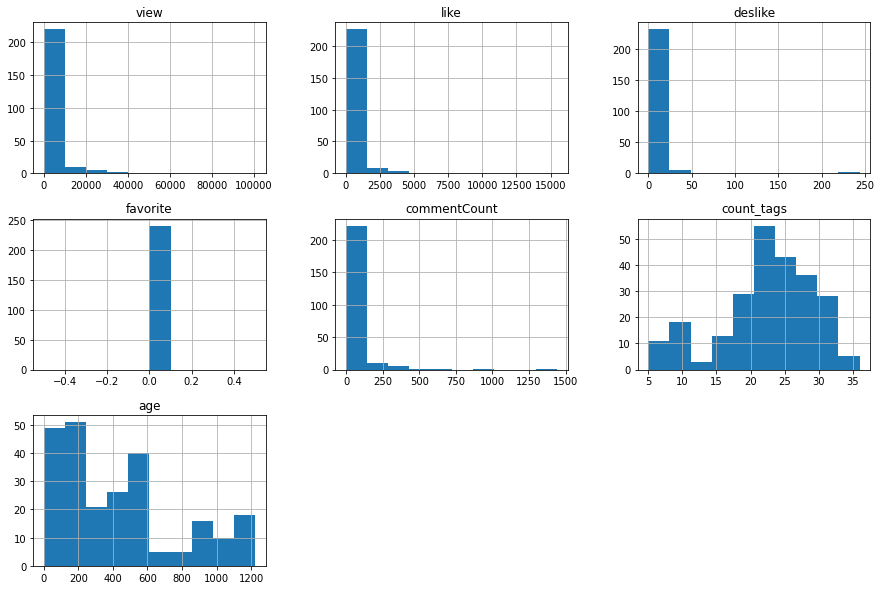

In [181]:
df1.hist(bins = 10, figsize=(15,10));

#### Correlação entre os dados

Será que há correlação entre os dados.

Vídeos postados anteriormente deveriam possuir mais comentários e visualização que os atuais?

Vídeos com mais tags são mais visualizados ou comentados?


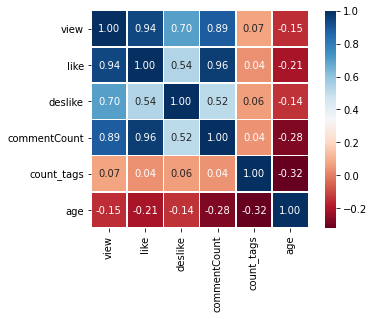

In [192]:
import seaborn as sns

df2 = df1.copy()
# optei por remover a feature favorite pois está zerada
df2.age = pd.to_numeric(df2.age)
corr = df2.drop('favorite', axis=1).corr()
sns.heatmap(corr, cmap='RdBu', fmt='.2f', square=True, linewidths=.5, linecolor='white', annot=True);

Interessante observar que não há uma correlação positiva entre a `idade` do vídeo e as demais informações (correlação negativa).

Como esperado `commentsCount` e `like` estão positivamente correlacionados com os views.

A quantidade de `tags` também não tem correlação positiva com a quantidade de `views`.

#### Velocidade de Publicações

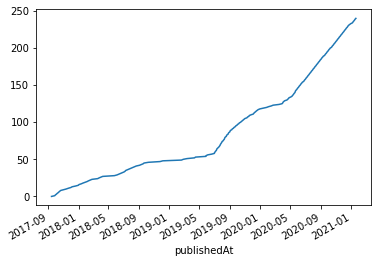

In [196]:
cumulative = df2.groupby(df2['publishedAt']).apply(lambda x: sum(df2['publishedAt']<x.name))
cumulative.plot()

Podemos observar que há 3 momentos distintos no canal.
* no início a velocidade de publicação dos vídeos era menor que atualmente
* entre 09/2018 e 09/2019 houve uma diminuição na publicação
* no período após 09/2019 houve uma aceleração na produção de conteúdo.

# Conclusão

Esse notebbook iniciou-se como um exercício prático para elaboração de um web scraper a fim de obtenção dos dados de um canal no Youtube.

Aprofundando no assunto, percebo que acabei violando as regras de utilização e acabei bloqueado. O Youtube tem sérias restrições a acessos automatizados.

A fim de contornar a restrição procurei obter os dados a partir da API do Youtube que se mostrou muito mais amigável.
Aproveitei ainda para reforçar alguns conceitos de tratamento e visualização de dados.

Se você chegou até aqui não deixe de acompanhar o canal [Programação Dinâmica](https://www.youtube.com/channel/UC70mr11REaCqgKke7DPJoLg), pois a Kizzy e o Hallison possuem uma didática excelente para ensinar "sobre programação, ciência de dados e inteligência artificial e promovemos discussões sobre novas tecnologias e seus impactos na sociedade."